In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.stats import shapiro, ttest_ind, f_oneway

In [49]:
df = pd.read_csv("/kaggle/input/fictional-character-battle-outcome-prediction/fictional_character_battles_complex.csv")

In [50]:
df.head()

,Character,Universe,Strength,Speed,Intelligence,SpecialAbilities,Weaknesses,BattleOutcome
0,Wonder Woman,Marvel,7,8,3,Telekinesis,Kryptonite,0
1,Iron Man,Marvel,4,7,9,Telekinesis,Kryptonite,0
2,Iron Man,DC Comics,8,7,5,Telekinesis,Magic,0
3,Spider-Man,DC Comics,5,6,10,Telekinesis,Kryptonite,0
4,Flash,Marvel,7,6,2,Invisibility,Magic,0


In [51]:
df.isnull().sum()

Character           0
Universe            0
Strength            0
Speed               0
Intelligence        0
SpecialAbilities    0
Weaknesses          0
BattleOutcome       0
dtype: int64

In [52]:
# Check for duplicates and remove them
duplicates = df.duplicated()
print("\nNumber of Duplicates:", duplicates.sum())


Number of Duplicates: 6


In [53]:
df = df.drop_duplicates()

In [54]:
# Basic info and statistics
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2345 entries, 0 to 2350
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Character         2345 non-null   object
 1   Universe          2345 non-null   object
 2   Strength          2345 non-null   int64 
 3   Speed             2345 non-null   int64 
 4   Intelligence      2345 non-null   int64 
 5   SpecialAbilities  2345 non-null   object
 6   Weaknesses        2345 non-null   object
 7   BattleOutcome     2345 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 164.9+ KB


In [55]:
print("\nData Description:\n", df.describe())


Data Description:
           Strength        Speed  Intelligence  BattleOutcome
count  2345.000000  2345.000000   2345.000000    2345.000000
mean      5.441365     5.481450      5.550107       0.278038
std       2.896110     2.858841      2.861892       0.448128
min       1.000000     1.000000      1.000000       0.000000
25%       3.000000     3.000000      3.000000       0.000000
50%       5.000000     6.000000      6.000000       0.000000
75%       8.000000     8.000000      8.000000       1.000000
max      10.000000    10.000000     10.000000       1.000000


In [56]:
# Calculate IQR
Q1 = df[['Strength', 'Speed', 'Intelligence']].quantile(0.25)
Q3 = df[['Strength', 'Speed', 'Intelligence']].quantile(0.75)
IQR = Q3 - Q1
# Remove outliers
df = df[~((df[['Strength', 'Speed', 'Intelligence']] < (Q1 - 1.5 * IQR)) | (df[['Strength', 'Speed', 'Intelligence']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [57]:
# Normalize data using Quantile Transformer and check with Shapiro-Wilk test
for column in ['Strength', 'Speed', 'Intelligence']:
    qt = QuantileTransformer()
    df[[column]] = qt.fit_transform(df[[column]])
    # Check normalization with Shapiro-Wilk test
    stat, p = shapiro(df[column])
    print(f'\nShapiro-Wilk Test for {column}: Statistics=%.3f, p=%.3f' % (stat, p))
    if p < 0.05:
        # Apply Power Transformer if not normally distributed
        pt = PowerTransformer()
        df[[column]] = pt.fit_transform(df[[column]])


Shapiro-Wilk Test for Strength: Statistics=0.947, p=0.000

Shapiro-Wilk Test for Speed: Statistics=0.948, p=0.000

Shapiro-Wilk Test for Intelligence: Statistics=0.948, p=0.000


In [58]:
# t-test between two groups (example)
t_stat, t_p = ttest_ind(df[df['Universe'] == 'Marvel']['Strength'], df[df['Universe'] == 'DC Comics']['Strength'])
print('\nT-test: t=%.3f, p=%.3f' % (t_stat, t_p))


T-test: t=1.512, p=0.131


In [59]:
print("\n--- T-tests ---")
t_test_results = []
for col1 in ['Strength', 'Speed', 'Intelligence']:
    for col2 in ['Strength', 'Speed', 'Intelligence']:
        if col1 != col2:
            t_stat, t_p = ttest_ind(df[col1], df[col2])
            t_test_results.append({
                'Comparison': f'{col1} vs {col2}',
                'T Statistic': t_stat,
                'p-value': t_p
            })
            print(f'T-test between {col1} and {col2}: t-statistic={t_stat:.3f}, p-value={t_p:.3f}')


--- T-tests ---
T-test between Strength and Speed: t-statistic=-0.000, p-value=1.000
T-test between Strength and Intelligence: t-statistic=0.000, p-value=1.000
T-test between Speed and Strength: t-statistic=0.000, p-value=1.000
T-test between Speed and Intelligence: t-statistic=0.000, p-value=1.000
T-test between Intelligence and Strength: t-statistic=-0.000, p-value=1.000
T-test between Intelligence and Speed: t-statistic=-0.000, p-value=1.000


In [60]:
print("\n--- ANOVA ---")
anova_results = {}
anova_stat, anova_p = f_oneway(df['Strength'], df['Speed'], df['Intelligence'])
anova_results['ANOVA'] = {
    'F-statistic': anova_stat,
    'p-value': anova_p
}
print(f'ANOVA: F-statistic={anova_stat:.3f}, p-value={anova_p:.3f}')


--- ANOVA ---
ANOVA: F-statistic=0.000, p-value=1.000


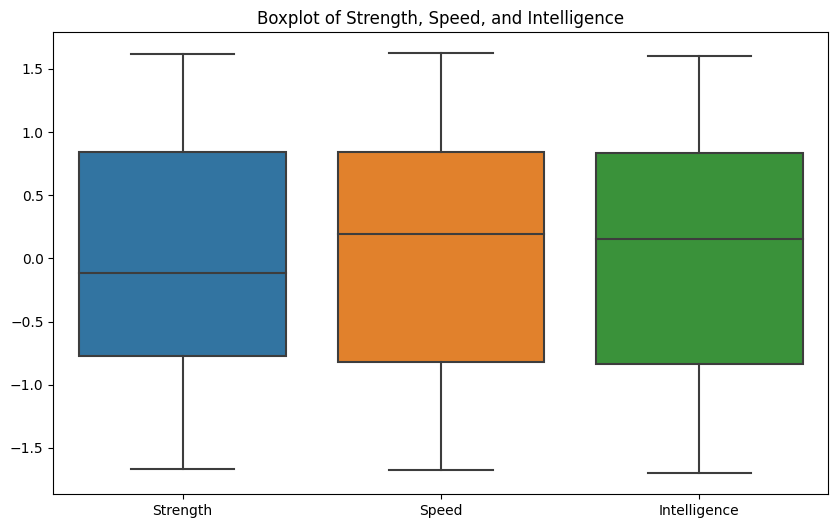

In [61]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Strength', 'Speed', 'Intelligence']])
plt.title("Boxplot of Strength, Speed, and Intelligence")
plt.show()

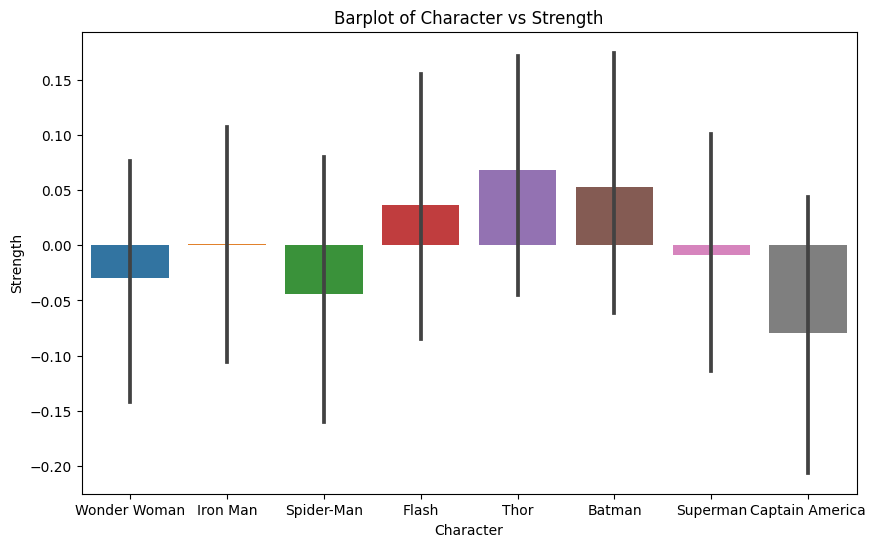

In [62]:
# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Character', y='Strength', data=df)
plt.title("Barplot of Character vs Strength")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


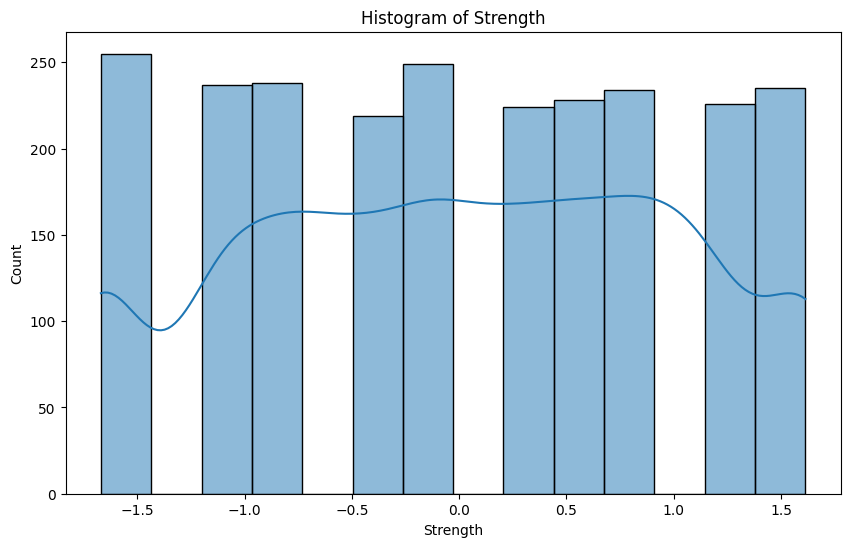

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


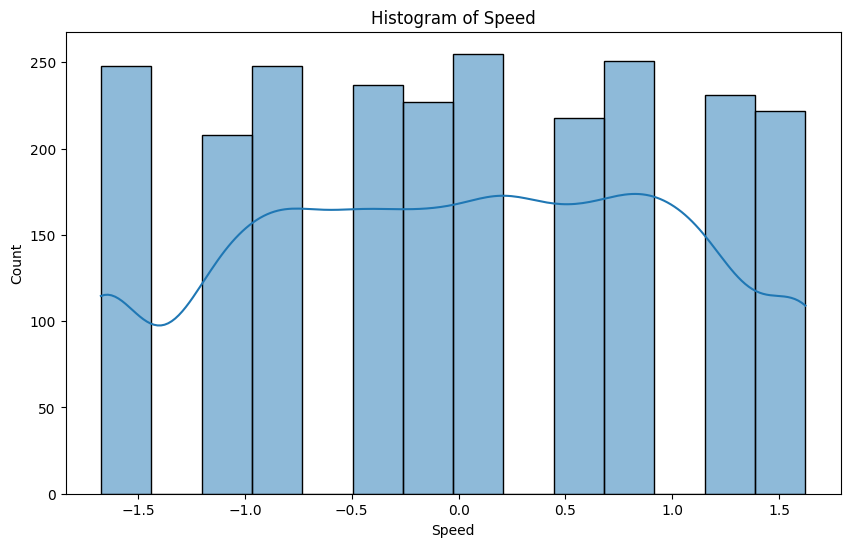

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


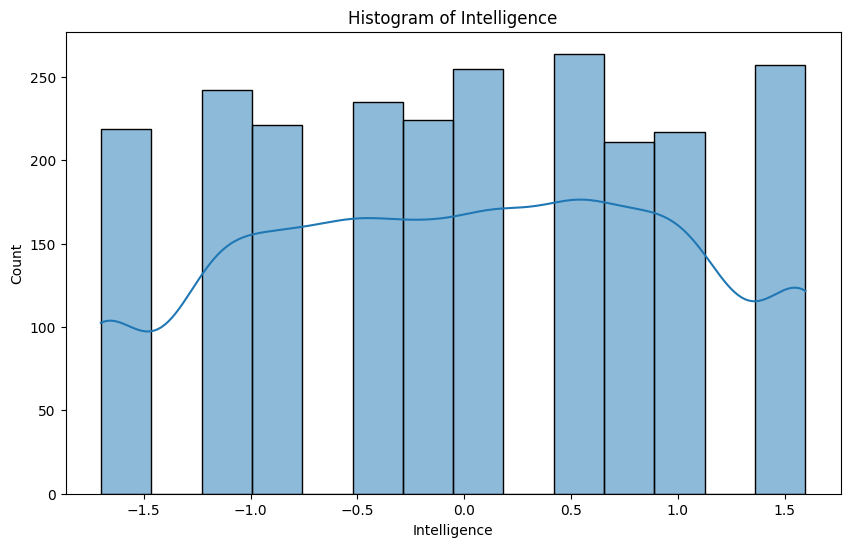

In [63]:
numerical_columns = ['Strength', 'Speed', 'Intelligence']
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f"Histogram of {column}")
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


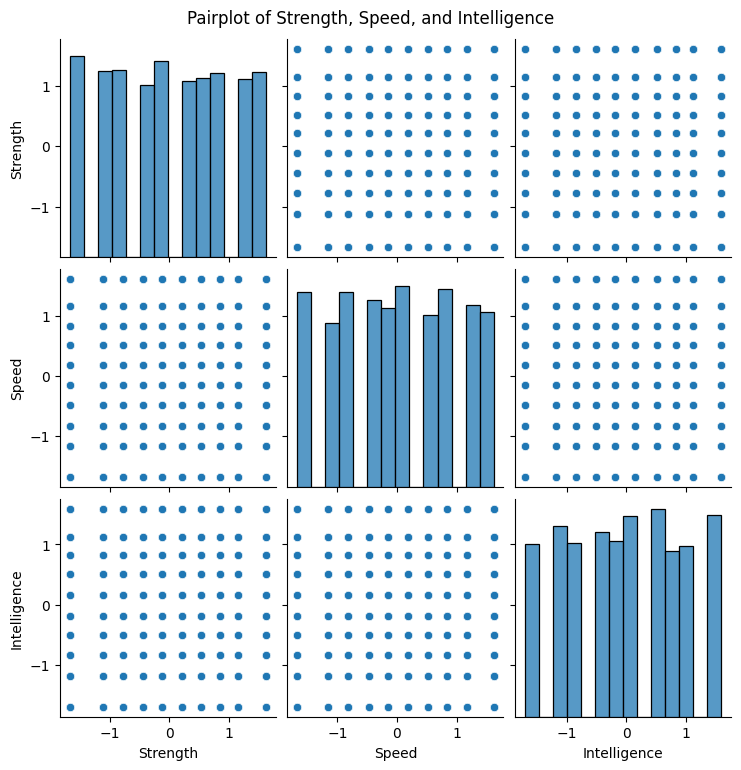

In [64]:
# Pairplot
sns.pairplot(df[['Strength', 'Speed', 'Intelligence']])
plt.suptitle("Pairplot of Strength, Speed, and Intelligence", y=1.02)
plt.show()

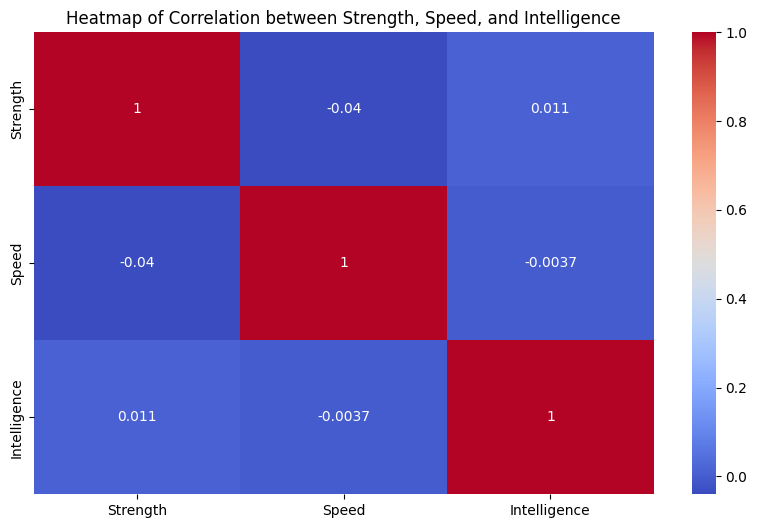

In [65]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Strength', 'Speed', 'Intelligence']].corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap of Correlation between Strength, Speed, and Intelligence")
plt.show()

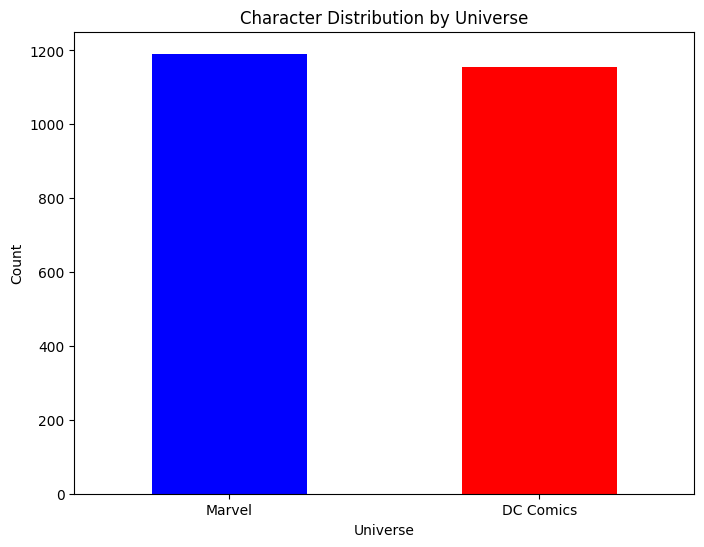

In [66]:
# Character distribution by Universe
plt.figure(figsize=(8, 6))
df['Universe'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Character Distribution by Universe')
plt.xlabel('Universe')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Marvel', 'DC Comics'], rotation=0)
plt.show()

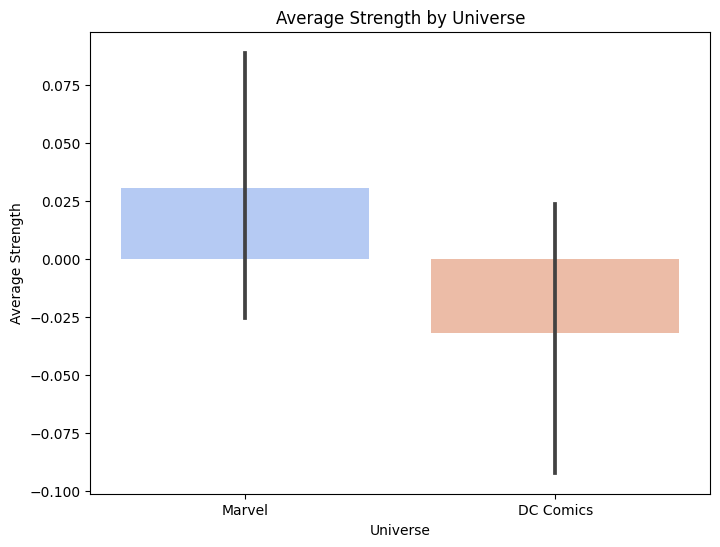

In [67]:
# Average Strength by Universe
plt.figure(figsize=(8, 6))
sns.barplot(x='Universe', y='Strength', data=df, estimator=np.mean, palette='coolwarm')
plt.title('Average Strength by Universe')
plt.xlabel('Universe')
plt.ylabel('Average Strength')
plt.show()

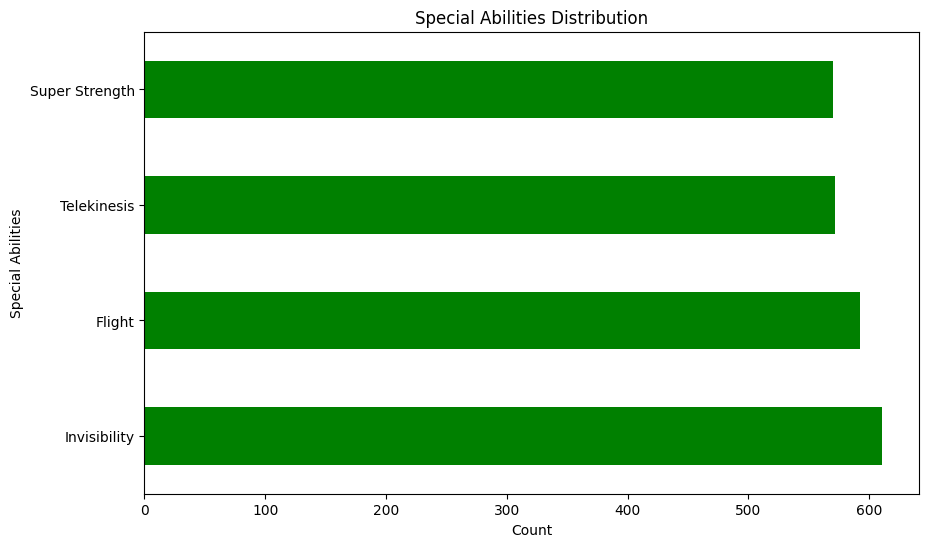

In [68]:
# Special Abilities Distribution
plt.figure(figsize=(10, 6))
df['SpecialAbilities'].value_counts().plot(kind='barh', color='green')
plt.title('Special Abilities Distribution')
plt.xlabel('Count')
plt.ylabel('Special Abilities')
plt.show()


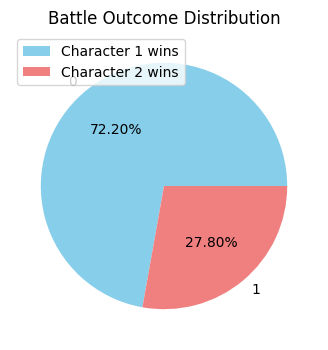

In [69]:
# Battle Outcome Distribution
plt.figure(figsize=(6, 4))
df['BattleOutcome'].value_counts().plot(kind='pie', autopct='%1.2f%%', colors=['skyblue', 'lightcoral'])
plt.title('Battle Outcome Distribution')
plt.ylabel('')
plt.legend(['Character 1 wins', 'Character 2 wins'], loc='best')
plt.show()


In [70]:
# Encode categorical variables
le = LabelEncoder()
df['Character'] = le.fit_transform(df['Character'])
df['Universe'] = le.fit_transform(df['Universe'])
df['SpecialAbilities'] = le.fit_transform(df['SpecialAbilities'])
df['Weaknesses'] = le.fit_transform(df['Weaknesses'])

In [71]:
# Split data into train and test sets
X = df.drop('BattleOutcome', axis=1)
y = df['BattleOutcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# Define classifier models
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'CatBoost': CatBoostClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'XGBoost': XGBClassifier(),
    'Bagging Classifier': BaggingClassifier()
}


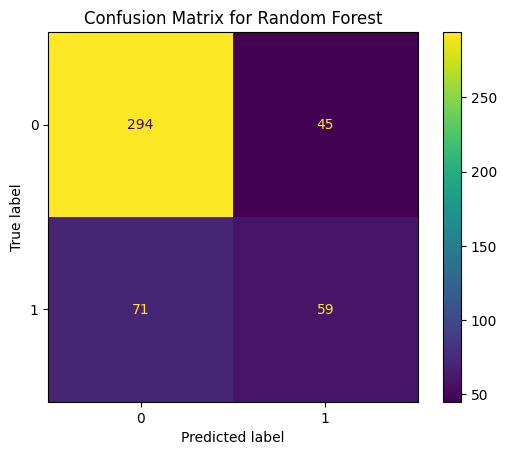

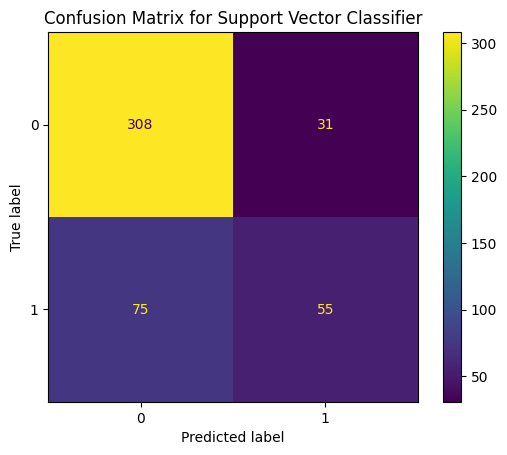

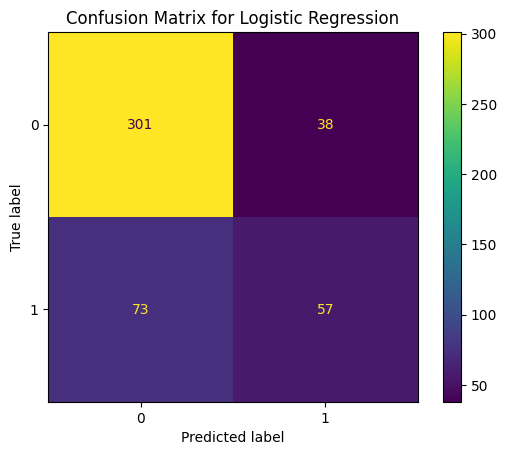

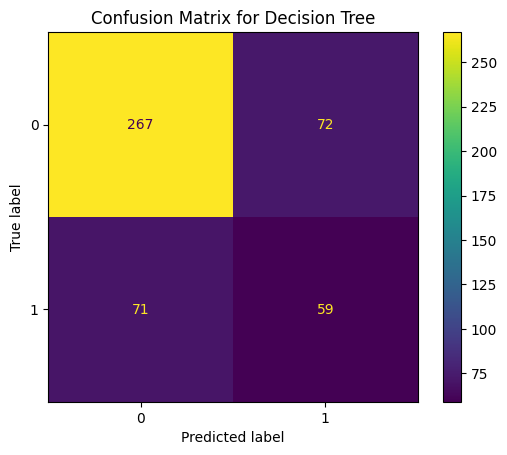

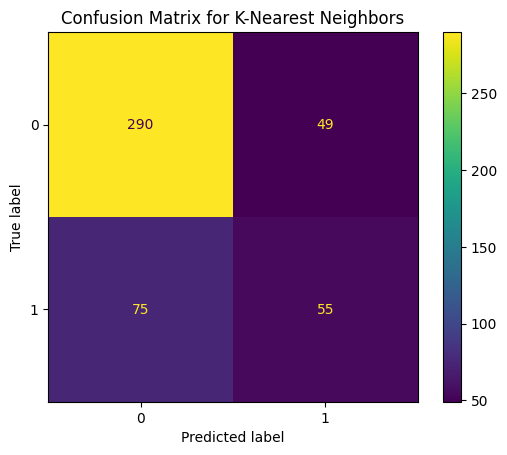

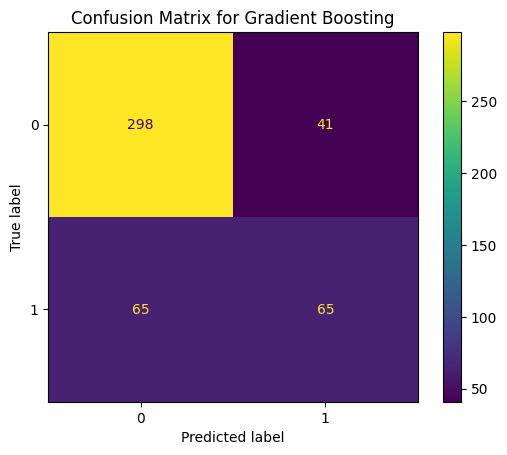

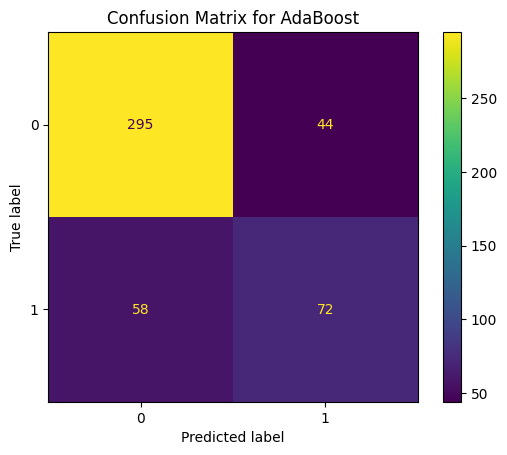

Learning rate set to 0.013477
0:	learn: 0.6838656	total: 1.63ms	remaining: 1.63s
1:	learn: 0.6758078	total: 2.98ms	remaining: 1.49s
2:	learn: 0.6674481	total: 4.32ms	remaining: 1.43s
3:	learn: 0.6583720	total: 5.57ms	remaining: 1.39s
4:	learn: 0.6509284	total: 6.87ms	remaining: 1.37s
5:	learn: 0.6431915	total: 8.11ms	remaining: 1.34s
6:	learn: 0.6373617	total: 9.34ms	remaining: 1.32s
7:	learn: 0.6305452	total: 10.6ms	remaining: 1.31s
8:	learn: 0.6240415	total: 11.9ms	remaining: 1.3s
9:	learn: 0.6181451	total: 13.1ms	remaining: 1.3s
10:	learn: 0.6116032	total: 14.7ms	remaining: 1.32s
11:	learn: 0.6057016	total: 16.1ms	remaining: 1.32s
12:	learn: 0.5992679	total: 17.4ms	remaining: 1.32s
13:	learn: 0.5938989	total: 18.7ms	remaining: 1.31s
14:	learn: 0.5881622	total: 20ms	remaining: 1.31s
15:	learn: 0.5824536	total: 21.3ms	remaining: 1.31s
16:	learn: 0.5772842	total: 22.6ms	remaining: 1.31s
17:	learn: 0.5721793	total: 23.9ms	remaining: 1.3s
18:	learn: 0.5690468	total: 25.2ms	remaining: 1.3

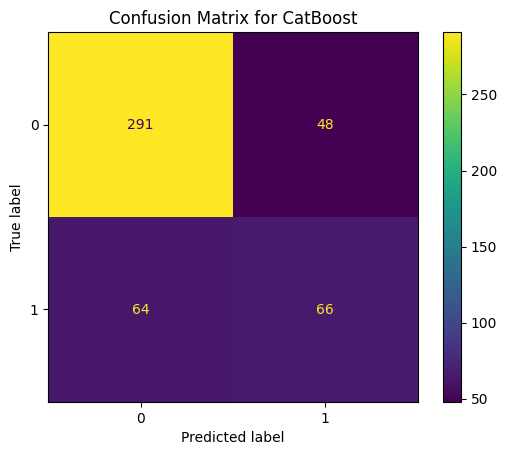

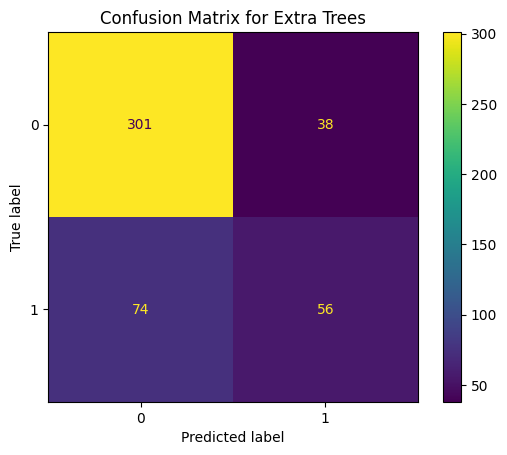

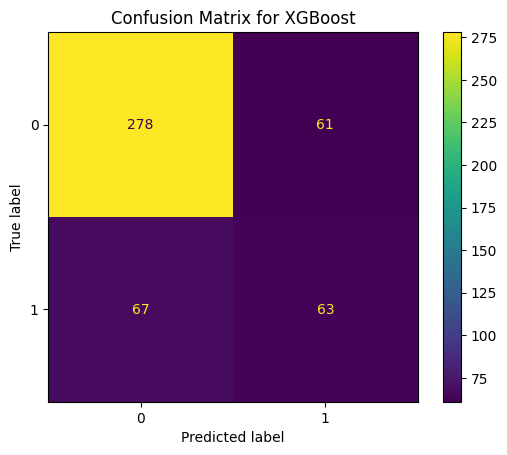

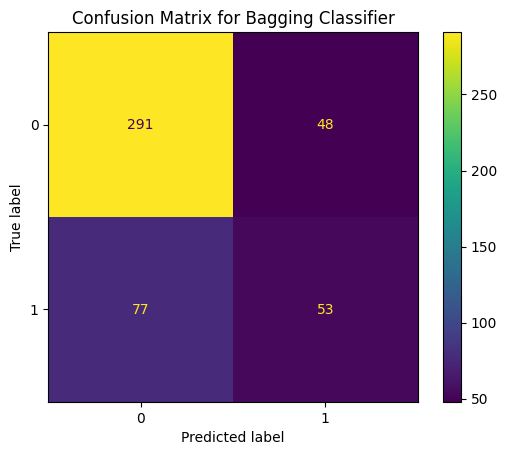

                        Model  Accuracy  Precision    Recall  F1 Score
0               Random Forest  0.752665   0.686394  0.660551  0.669750
1   Support Vector Classifier  0.773987   0.721856  0.665816  0.681222
2         Logistic Regression  0.763326   0.702406  0.663184  0.675493
3               Decision Tree  0.695096   0.620161  0.620728  0.620441
4         K-Nearest Neighbors  0.735608   0.661683  0.639267  0.646975
5           Gradient Boosting  0.773987   0.717072  0.689528  0.699925
6                    AdaBoost  0.782516   0.728192  0.712026  0.718984
7                    CatBoost  0.761194   0.699333  0.683050  0.689800
8                 Extra Trees  0.761194   0.699206  0.659337  0.671569
9                     XGBoost  0.727079   0.656931  0.652337  0.654464
10         Bagging Classifier  0.733475   0.657757  0.633050  0.641036


In [73]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Initialize a DataFrame to store evaluation results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
# Train and evaluate models
evaluation_results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']
    # Append results to list
    evaluation_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
# Create DataFrame from evaluation results
results = pd.DataFrame(evaluation_results)
# Save results to CSV
results.to_csv('evaluation_results.csv', index=False)
# Display evaluation results in table form
print(results)


In [74]:
!pip install mlextend

ERROR: Could not find a version that satisfies the requirement mlextend (from versions: none)
ERROR: No matching distribution found for mlextend


In [75]:
from mlxtend.classifier import StackingClassifier
# Define base learners and meta learner for stacking classifier
base_learners = [RandomForestClassifier(), SVC(), LogisticRegression(), DecisionTreeClassifier(), 
                 KNeighborsClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(),
                 CatBoostClassifier(), ExtraTreesClassifier(), XGBClassifier(), BaggingClassifier()]
meta_learner = LogisticRegression()
# Initialize Stacking Classifier
stack = StackingClassifier(classifiers=base_learners, meta_classifier=meta_learner, use_probas=False, average_probas=False)
# Train Stacking Classifier
stack.fit(X_train, y_train)


Learning rate set to 0.013477
0:	learn: 0.6838656	total: 1.71ms	remaining: 1.71s
1:	learn: 0.6758078	total: 3.06ms	remaining: 1.52s
2:	learn: 0.6674481	total: 4.36ms	remaining: 1.45s
3:	learn: 0.6583720	total: 5.62ms	remaining: 1.4s
4:	learn: 0.6509284	total: 7ms	remaining: 1.39s
5:	learn: 0.6431915	total: 8.45ms	remaining: 1.4s
6:	learn: 0.6373617	total: 9.69ms	remaining: 1.37s
7:	learn: 0.6305452	total: 10.9ms	remaining: 1.36s
8:	learn: 0.6240415	total: 12.2ms	remaining: 1.34s
9:	learn: 0.6181451	total: 13.5ms	remaining: 1.33s
10:	learn: 0.6116032	total: 14.7ms	remaining: 1.32s
11:	learn: 0.6057016	total: 16ms	remaining: 1.32s
12:	learn: 0.5992679	total: 17.3ms	remaining: 1.31s
13:	learn: 0.5938989	total: 18.5ms	remaining: 1.3s
14:	learn: 0.5881622	total: 19.7ms	remaining: 1.3s
15:	learn: 0.5824536	total: 21ms	remaining: 1.29s
16:	learn: 0.5772842	total: 22.3ms	remaining: 1.29s
17:	learn: 0.5721793	total: 23.5ms	remaining: 1.28s
18:	learn: 0.5690468	total: 24.6ms	remaining: 1.27s
19:

StackingClassifier(classifiers=[RandomForestClassifier(), SVC(),
                                LogisticRegression(), DecisionTreeClassifier(),
                                KNeighborsClassifier(),
                                GradientBoostingClassifier(),
                                AdaBoostClassifier(),
                                <catboost.core.CatBoostClassifier object at 0x7f117f84e860>,
                                ExtraTreesClassifier(),
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsamp...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...),
                                BaggingClassifier()],
                   meta_classifier=LogisticRegression())

In [76]:
# Predict with Stacking Classifier
y_pred_stack = stack.predict(X_test)
# Calculate evaluation metrics for Stacking Classifier
accuracy_stack = accuracy_score(y_test, y_pred_stack)
report_stack = classification_report(y_test, y_pred_stack, output_dict=True)
precision_stack = report_stack['macro avg']['precision']
recall_stack = report_stack['macro avg']['recall']
f1_score_stack = report_stack['macro avg']['f1-score']


In [77]:
# Append Stacking Classifier results to the evaluation results
evaluation_results.append({
    'Model': 'Stacking Classifier',
    'Accuracy': accuracy_stack,
    'Precision': precision_stack,
    'Recall': recall_stack,
    'F1 Score': f1_score_stack
})
# Update results DataFrame
results = pd.DataFrame(evaluation_results)
# Save updated results to CSV
results.to_csv('evaluation_results_with_stacking.csv', index=False)
# Display updated evaluation results in table form
print(results)

                        Model  Accuracy  Precision    Recall  F1 Score
0               Random Forest  0.752665   0.686394  0.660551  0.669750
1   Support Vector Classifier  0.773987   0.721856  0.665816  0.681222
2         Logistic Regression  0.763326   0.702406  0.663184  0.675493
3               Decision Tree  0.695096   0.620161  0.620728  0.620441
4         K-Nearest Neighbors  0.735608   0.661683  0.639267  0.646975
5           Gradient Boosting  0.773987   0.717072  0.689528  0.699925
6                    AdaBoost  0.782516   0.728192  0.712026  0.718984
7                    CatBoost  0.761194   0.699333  0.683050  0.689800
8                 Extra Trees  0.761194   0.699206  0.659337  0.671569
9                     XGBoost  0.727079   0.656931  0.652337  0.654464
10         Bagging Classifier  0.733475   0.657757  0.633050  0.641036
11        Stacking Classifier  0.750533   0.683425  0.659076  0.667849


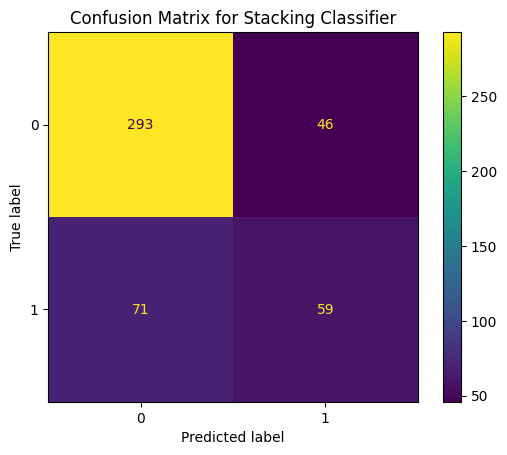

In [78]:
# Display confusion matrix for Stacking Classifier
cm_stack = confusion_matrix(y_test, y_pred_stack)
disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack)
disp_stack.plot()
plt.title("Confusion Matrix for Stacking Classifier")
plt.show()

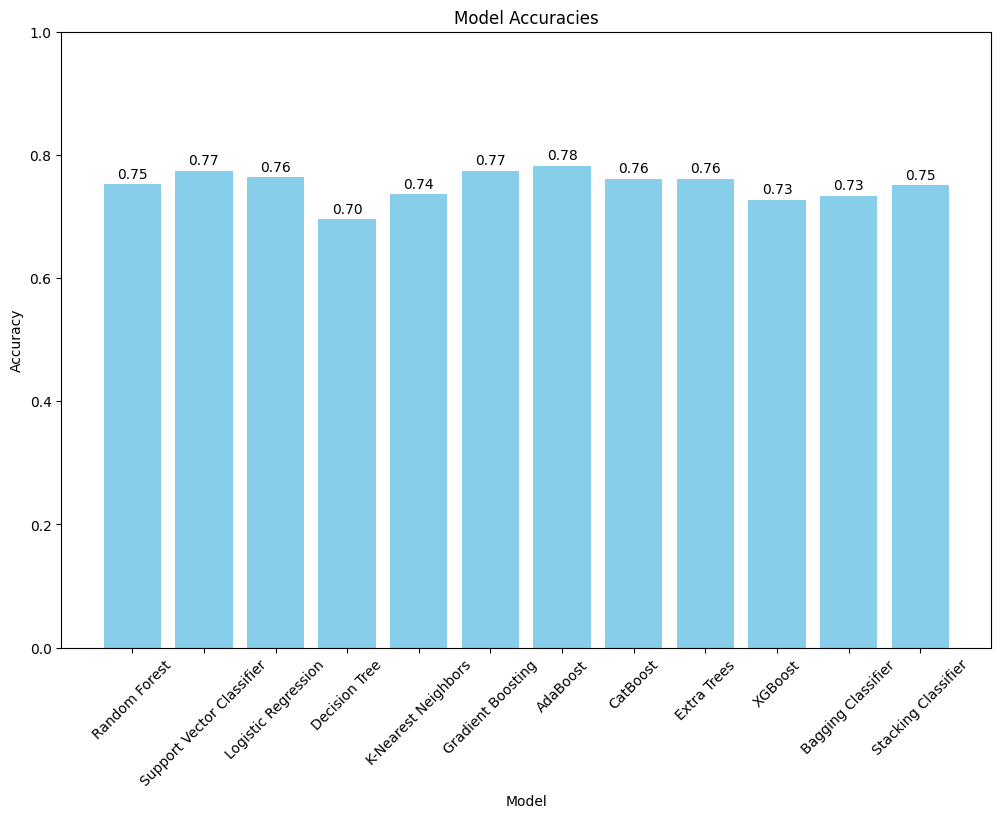

In [79]:
# Plot accuracies
plt.figure(figsize=(12, 8))
plt.bar(results['Model'], results['Accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i in range(len(results)):
    plt.text(i, results['Accuracy'][i] + 0.01, f"{results['Accuracy'][i]:.2f}", ha='center')
plt.show()